###Neural Networks in Numpy

We will design and train a 2 layer Neural Network with Numpy and use it classify MNIST digits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch Libraries
import torch
from torchvision import models,transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

### Data Loading


Helper function for loading data and creating dataLoaders for MNIST dataset.

In [2]:
# MNIST
def mnist(batch_sz, valid_size=0, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True, shuffle=False)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



creating train, val and test dataloaders for MNIST dataset.

In [3]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, val_loader, test_loader=mnist(batch_sz)

Training and networks parameters and hyperparamters and network initialization

We will implement the forward pass and backward  propagation equations that we derived in the lecture on Day 1. Variable "m" in the back propagation equation is the batch size.

torch.Size([64, 1, 28, 28])
64


tensor([7, 2, 4, 8, 6, 6, 9, 7, 5, 9, 9, 0, 8, 6, 2, 1, 7, 1, 5, 8, 0, 3, 1, 8,
        2, 7, 0, 2, 2, 9, 4, 8, 9, 3, 3, 4, 5, 3, 2, 2, 3, 8, 5, 3, 5, 6, 1, 9,
        7, 1, 2, 5, 0, 7, 0, 0, 3, 9, 1, 5, 5, 0, 9, 9])

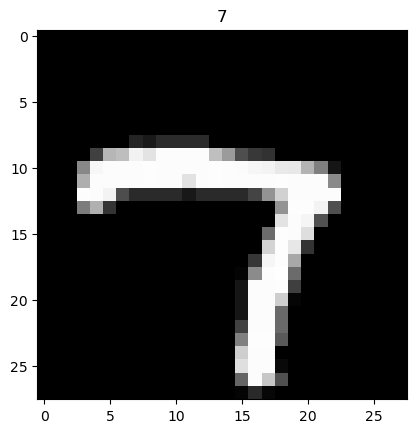

In [4]:
batch = next(iter(train_loader))
print(batch[0].shape)

for i in range(1):
  plt.figure()
  plt.imshow(batch[0][i,0,:,:],cmap='gray')
  plt.title(batch[1][i].item())

print(len(batch[0]))
batch[1]

The main training loop, with batch gradient decent.

In [10]:
class Linear:
    """
    X input size: (batch, p)
    """
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.W = np.random.randn(in_features, out_features)
        self.b = np.random.randn(out_features)
        # forward: Z (batch, out_features) <- X (batch, in_features) * W (in_features, out_features) + b (out_features)
        self.grad_W = None
        self.grad_b = None
        self.X = None
        self.batchSize = None

    def forward(self, X):
        self.X = X
        self.batchSize = X.shape[0]
        Z = np.dot(X, self.W) + self.b
        return Z

    def backward(self, dZ):
        # dZ (batch, out_features)
        # dW (in_features, out_f) <- X.T (in_features, batch) * dZ (batch, out_features)
        self.grad_W = np.dot(self.X.T, dZ)
        self.grad_b = np.sum(dZ, axis=0)
        dX = np.dot(dZ, self.W.T)
        return dX

    def update(self, lr):
        self.W -= lr * self.grad_W
        self.b -= lr * self.grad_b
        self.grad_W = None
        self.grad_b = None

class ReLU:
    def __init__(self):
        self.Z = None

    def forward(self, X):
        self.Z = np.maximum(X, 0)
        return self.Z

    def backward(self, dZ):
        dX = dZ * (self.Z > 0)
        return dX

class sigmoid:
    def __init__(self):
        self.Z = None

    def forward(self, X):
        self.Z = 1/(1+np.exp(-X))
        return self.Z

    def backward(self, dZ):
        dX = dZ * self.Z * (1-self.Z)
        return dX

class MSE:
    def __init__(self):
        self.y = None
        self.y_hat = None

    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = y_hat
        return np.mean((y - y_hat)**2)

    def backward(self):
        return 2*(self.y_hat - self.y)/self.y.shape[0]

class crossEntropy:
    """
    cross entropy loss for multi-class classification, y is one-hot encoded
    """
    def __init__(self):
        self.num_classes = None
        self.y = None
        self.y_hat = None

    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = y_hat
        self.num_classes = y.shape[1]
        return -np.sum(y*np.log(y_hat))/y.shape[0] #expectation CrossEntropy

    def backward(self):
        return -self.y/self.y_hat/self.y.shape[0] #expectation CrossEntropy

def accuracy(y, y_hat):
    """
    :param y: (batch, num_classes)
    :param y_hat: (batch, num_classes)
    """
    return np.mean(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1), axis=0)


In [18]:
model = [
    Linear(28*28, 50),
    sigmoid(),
    Linear(50, 10),
    sigmoid(),
    crossEntropy()
]
batch_size = 256
lr = 1e-1
epochs = 10
losses = []

In [22]:
# let me try whether it works

for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        # transform X_batch to (batch, 28*28)
        X_batch = X_batch.view(X_batch.shape[0], -1)
        # transform y_batch to one-hot encoding
        vec = y_batch.numpy()
        y_batch = np.zeros((y_batch.shape[0], 10))
        y_batch[np.arange(y_batch.shape[0]), vec] = 1
        # forward
        for layer in model[:-1]: # the last layer is the loss function, and it needs 2 inputs, so we don't forward it here
            X_batch = layer.forward(X_batch)
            # X_batch is the output of the layer, its size changes to the output size of the layer

        loss = model[-1].forward(y_batch, X_batch) # here we record the loss in the last layer(loss function)
        losses.append(loss)

        # backward
        ## In my torch-like design, the gradient is stored in the layer itself, so we need to backward from the last layer to the first layer
        dX = model[-1].backward()
        # dX is not the "gradient of X", but the gradient of current layer's input.
        for layer in model[-2::-1]: # from the second last layer to the first layer, because the last layer is the loss function
            dX = layer.backward(dX)

        ## after backward, the gradient is stored in the layer itself, so we can update the parameters

        # update
        ## should be just simple addition.
        for layer in model:
            # If it has func update, then update
            if hasattr(layer, "update"): # this looks like a powerful function
                layer.update(lr)
    print(f"epoch {epoch}, loss {loss}")
    print(f"epoch {epoch}, training accuracy {accuracy(y_batch, X_batch)}")
    # evaluate on test set
    X_test = val_loader.dataset.data.view(val_loader.dataset.data.shape[0], -1).numpy()
    y_test = np.zeros((val_loader.dataset.targets.shape[0], 10))
    y_test[np.arange(y_test.shape[0]), val_loader.dataset.targets.numpy()] = 1
    for layer in model[:-1]:
        X_test = layer.forward(X_test)
    print(f"epoch {epoch}, test accuracy {accuracy(y_test, X_test)}")

# plot loss
plt.plot(losses)
plt.title("loss")
plt.show()

epoch 0, loss 0.00018641529793587822
epoch 0, training accuracy 0.09375


C:\Users\Lifan Lin\AppData\Local\Temp\ipykernel_6080\4151497030.py:53: RuntimeWarning: overflow encountered in exp
  self.Z = 1/(1+np.exp(-X))


epoch 0, test accuracy 0.12668333333333334
epoch 1, loss 0.00013265489260334663
epoch 1, training accuracy 0.1875
epoch 1, test accuracy 0.12703333333333333
epoch 2, loss 0.0001723838249918556
epoch 2, training accuracy 0.15625
epoch 2, test accuracy 0.12728333333333333
epoch 3, loss 0.0003796147358027925
epoch 3, training accuracy 0.125
epoch 3, test accuracy 0.12736666666666666
epoch 4, loss 4.9270496467936695e-05
epoch 4, training accuracy 0.125
epoch 4, test accuracy 0.12775


KeyboardInterrupt: 

In [ ]:
def get_z(X, W, b):
  return W@X+b

def sigmoid(Z):
  return 1/(1+np.exp(-Z))

def loss(yhat,y):
  l = np.mean (np.sum(-y*np.log(yhat), axis = 0))
  return l

Accuray is 0.8276333333333333
10342 out of 60000 are incorreclty labeled
Accuray is 0.9227
4638 out of 60000 are incorreclty labeled
Accuray is 0.9338666666666666
3968 out of 60000 are incorreclty labeled
Accuray is 0.9406166666666667
3563 out of 60000 are incorreclty labeled
Accuray is 0.94455
3327 out of 60000 are incorreclty labeled
Accuray is 0.9479
3126 out of 60000 are incorreclty labeled
Accuray is 0.9503833333333334
2977 out of 60000 are incorreclty labeled
Accuray is 0.9509833333333333
2941 out of 60000 are incorreclty labeled


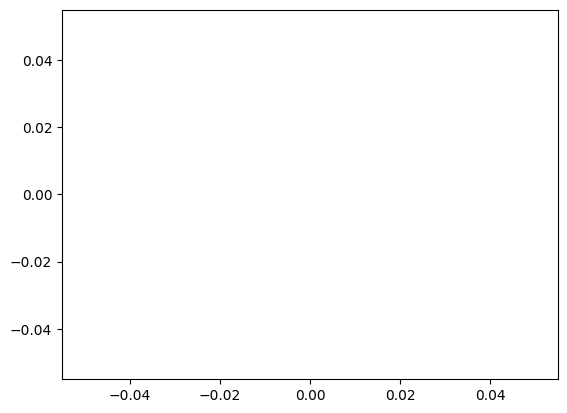

In [ ]:
ni = 28*28 # no of input feature
nh = 50   # no of hidden units/nodes
no = 10   #no of out channel (has to be equal ot the number of classes)

W1 = np.random.randn(nh,ni) # the number of rows of w1 has to equal teh of hidden untis na dhte numbero fcolumsn have ot equal the numebrof rows of X
b1 = np.zeros((nh , 1)) # b1 is a column vector and the rows have to match z1

W2 = np.random.randn(no ,nh) # the number of rows have to be equal to out channels nad the no of columsn eaul to the number of rows of A1
b2 = np.zeros((no, 1)) # column vector, rows equal to z2

num_epochs = 8
lr = 0.1

# X [x_1, x_2, x_3, ...  x_N]
ls = []
for i in range(num_epochs):
  error = 0
  num_images = 0
  correct = 0
  total = 0
  total_loss = 0
  for batch in train_loader:
    X = batch[0]
    labels = batch[1]
    X = batch[0].numpy().reshape(-1,28*28).T
    y = np.zeros((no, X.shape[1]))
    y[labels, np.arange(y.shape[1])] = 1

    # y[[2, 9,4,7],[0,1,2,3]]
    #y[2,0]=1
    #y[9,1] =1
    #y[4,2]=1
    #y[7,3] =1

    #forward pass
    Z1 = W1@X + b1 ##nn.Linear (layer 1)
    A1 = sigmoid(Z1) #torch.sigmoid

    Z2 = W2@A1 + b2  ##nn.Linear (layer 2)
    yhat = sigmoid(Z2) #

    #backward pass
    dZ2 = yhat - y

    dW2 = dZ2 @ A1.T
    db2 = np.sum(dZ2, axis =1 , keepdims = True)

    dZ1 = W2.T @ dZ2 * A1*(1-A1)

    dW1 = dZ1 @ X.T
    db1 = np.sum(dZ1, axis =1 , keepdims = True)


    #optimzation step
    #print(np.max(W1), np.max(dW1), np.max(W2), np.max(dW2))
    # optimization step
    W2 -= lr*dW2
    b2 -= lr*db2
    W1 -= lr*dW1
    b1 -= lr*db1



    #calcuating classification error
    num_images += X.shape[1]
    error += np.sum(( np.argmax(yhat, axis = 0)!= labels.numpy())*1)
    #calcuating classification error
    pred = np.argmax(yhat, axis = 0)
    correct+= np.sum(labels.numpy() == pred)
    total+=yhat.shape[1]

  print(f"Accuray is {correct/total}")
  print(f"{error} out of {num_images} are incorreclty labeled")


plt.plot(ls)








In [ ]:
#yhat ---> column 1 (1 data point) ---[[0],[0.1],[0],[0.5],[0.3],[0]...]
# y ---> colum 1 (1 data point)----> 2 --->[[0],[0],[1],[0],[0],...] --> one hot encoding


In [ ]:
y

In [ ]:
labels==y

In [ ]:
plt.imshow(X[:,0].reshape(28,28))


In [ ]:
dW2